# Classifying handwritten digits

In [1]:
import sklearn
sklearn.__version__ # 버전 0.5.x 이상인지 확인하길 바랍니다.

'1.2.2'

In [2]:
#!pip install scikit-datasets

#택 1

#!pip install scikit-datasets --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org

In [3]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values
y = y.astype(int).values

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
# [-1, 1] 범위로 정규화:

X = ((X / 255.) - .5) * 2

## MNIST 데이터 확인하기

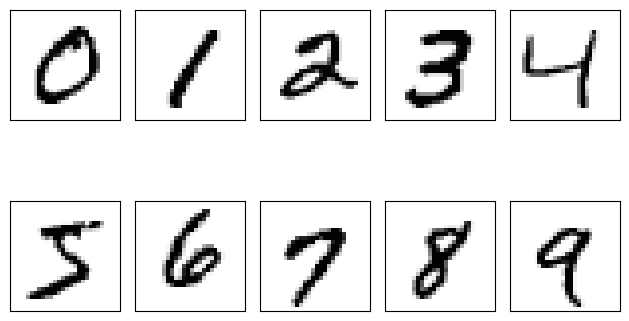

In [6]:
# 각 클래스의 첫번째 글자를 불러와서 시각화 해봅니다.

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

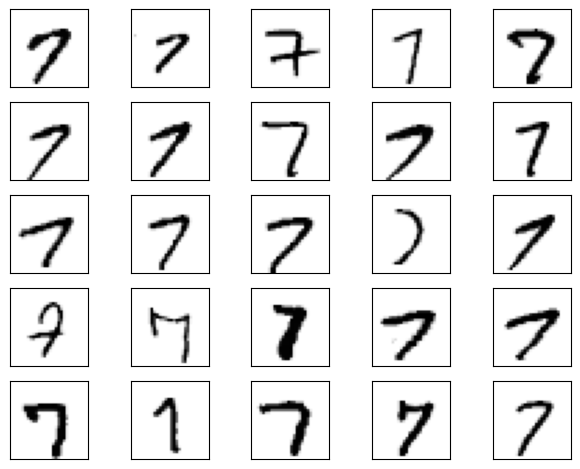

In [7]:
### 25개의 각기 다른 7번 확인

fig, ax = plt.subplots(nrows=5, #행
                       ncols=5, #열
                       sharex=True,
                       sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

# plt.savefig('figures/11_5.png', dpi=300)
### 이미지를 저장할때 해상도 dpi 300이상으로 저장하세요 (보통 논문에 넣을때도 300dpi 이상으로 첨부합니다.)
plt.show()

In [8]:
### 데이터 셋 분리하기 -> Train, Validation, Test

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [9]:
# 그냥 만들어본거고 사용하지 않을거기 때문에 메모리를 위해 지워줍니다.
del X_temp, y_temp, X, y

# 멀티 레이어 퍼셉트론 구현하기

## 깡 코딩 자료를 확인하기

In [10]:
import numpy as np


def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [11]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### 출력 레이어 가중치
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## 다시 사용하기 용이하기 위함

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"


        ## 출력 가중치에 대한 gradient(공간에 대한 기울기)

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [12]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

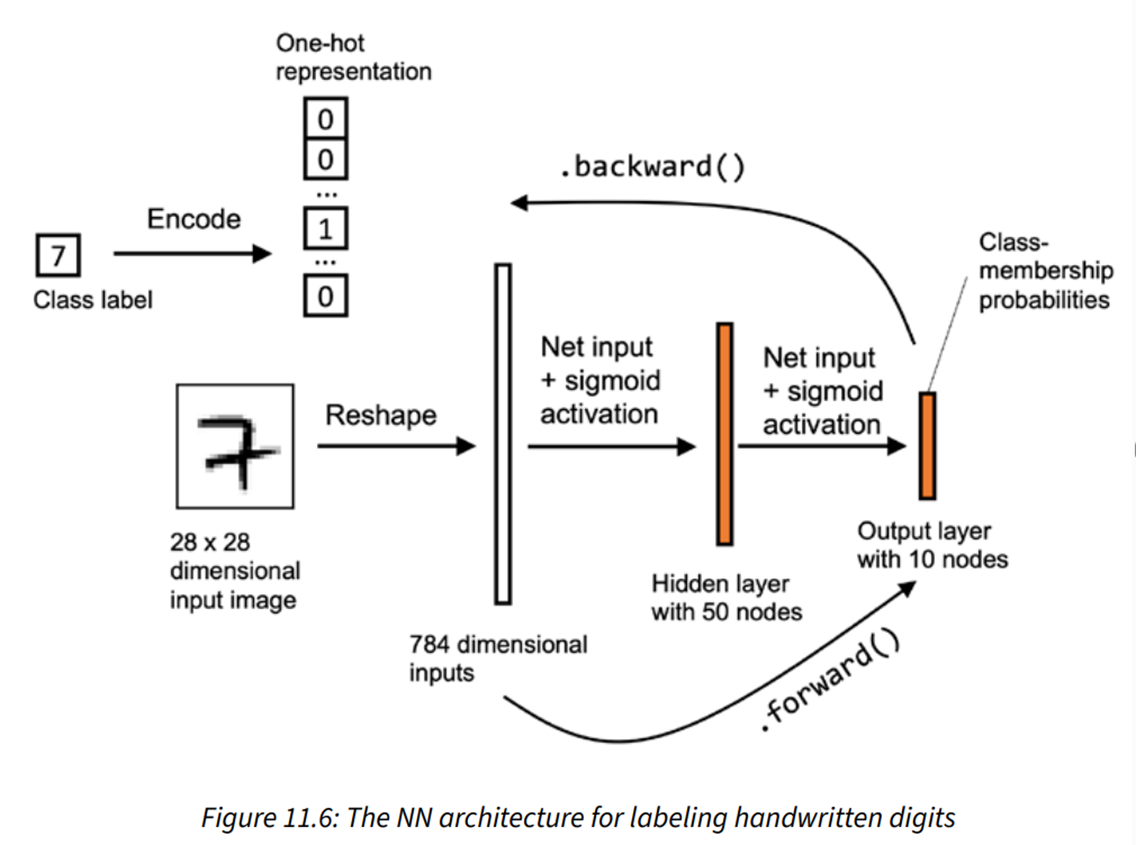

### Defining data loaders

In [13]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

In [14]:
# 트레이닝 epoch 반복
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen: break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


### 손실 및 정확도를 계산하는 함수 정의하기

In [15]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [16]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [17]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [18]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [19]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(model,
                                                     X_train, y_train,
                                                     X_valid, y_valid,
                                                     num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

## 신경망 성능 평가

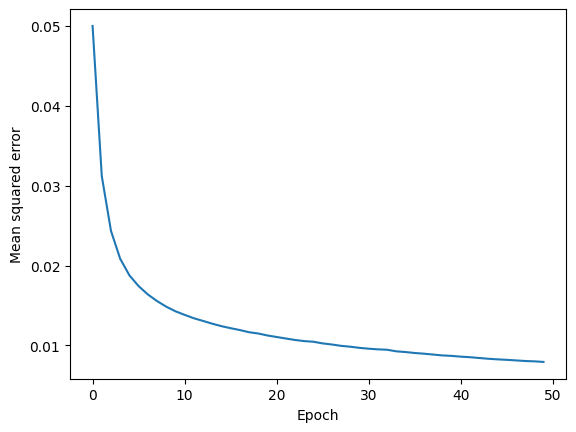

In [20]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

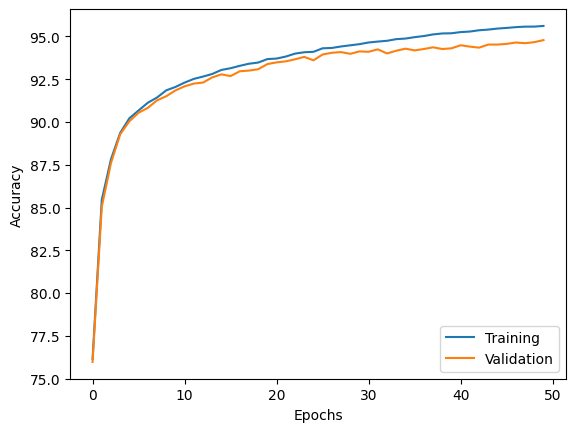

In [21]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [22]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


### 실패 사례 그리기 (plotting)

In [23]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

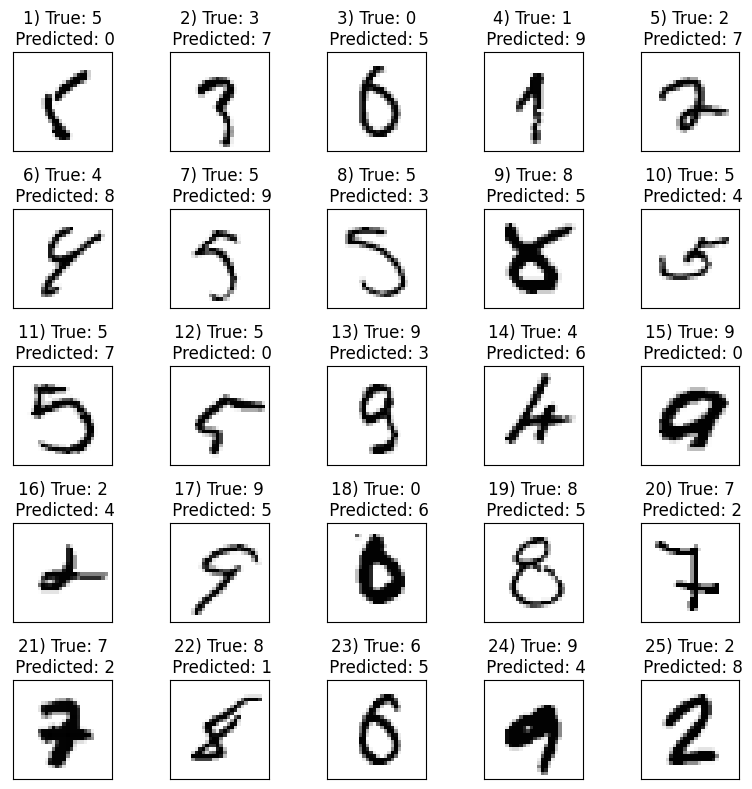

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

# 또 다른 방식으로 MLP를 적용해보자

- 책에서 주어진 코드는 멀티 레이어와 역전파 원리를 설명하기 위해서 저자가 모든 함수를 보여주었다.
- 위의 예시에서는 저자가 직접 구현을 하였고, 일반적으론 기존의 라이브러리를 활용합니다.
- 예를 들어 scikit-learn 의 MLP을 사용할 수 도 있고, 텐서플로우나 파이토치를 통해 구현할 수 도 있습니다.
- 이번 예시에서는 scikit-learn의 MLP를 활용하여 해보겠습니다.

### 위스콘신 유방암 데이터를 활용하여 MLP 사용해보기

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()   #유방암 환자 데이터
x = cancer.data
y = cancer.target

print('<wisconsin breast cancer data set>')
print('  data shape : ',x.shape)
print('target shape : ',y.shape)

<wisconsin breast cancer data set>
  data shape :  (569, 30)
target shape :  (569,)


- 위스콘신 유방암 데이터 세트 (wisconsin breast cancer dataset)
- 데이터수는 569개
- 속성은 30개

In [26]:
np.unique(cancer.target,return_counts=True)

(array([0, 1]), array([212, 357]))

- 타겟은 악성, 양성 (총 2개 클래스)

In [27]:
## 데이터 분할하기

x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size = 0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [28]:
scaler = StandardScaler()   #데이터 전처리
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train) #평균 0 , 분산 1로 조정
x_val_scaled = scaler.transform(x_val) # 평균 0 , 분산 1로 조정

### MLPClassifier 적용하기

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,10), # 2개의 은닉층을 만들고 각 계층별로 10개의 노드씩 할당
                    activation='logistic', #logistic => sigmoid 0~1
                    solver='sgd', #가중치 최적화를 위해 사용하는 함수 : 확률적 경사 하강법(SGD: Stochastic Gradient Descent)
                    alpha=0.01, #신경망 내의 정규화 파라미터(L2규제의 양)
                    batch_size=32,
                    learning_rate_init=0.1, max_iter=1000)

In [30]:
mlp.fit(x_train_scaled,y_train)
mlp.score(x_val_scaled,y_val)

0.989010989010989

- 성능 출력
- 정밀도, 재현율, F1 점수 또한 같이 확인해보겠습니다.

In [31]:
x_test_scaled = scaler.transform(x_test) # 평균 0 , 분산 1로 조정

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = mlp.predict(x_test_scaled)

accuracy_score(y_test, predictions)

0.9649122807017544

In [33]:
precision_score(y_test, predictions)

0.9857142857142858

In [34]:
recall_score(y_test, predictions)

0.9583333333333334

In [35]:
print(f1_score(y_test, predictions))

0.971830985915493
